Preprocessing data...
Splitting data...
Building and training model...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step - accuracy: 0.7943 - loss: 1.4226 - val_accuracy: 0.9208 - val_loss: 1.2627
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.9356 - loss: 0.8787 - val_accuracy: 0.8796 - val_loss: 0.9526
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9436 - loss: 0.6637 - val_accuracy: 0.8510 - val_loss: 0.8059
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9560 - loss: 0.5026 - val_accuracy: 0.8732 - val_loss: 0.6735
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9310 - loss: 0.4886 - val_accuracy: 0.9271 - val_loss: 0.6124
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9667 - loss: 0.3401 - val_accuracy: 0.9461 - val_loss: 0.5062
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1353s 35s/step - accuracy: 0.9687 - loss: 0.2711 - val_accuracy: 0.9334 - val_loss: 0.4357
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 

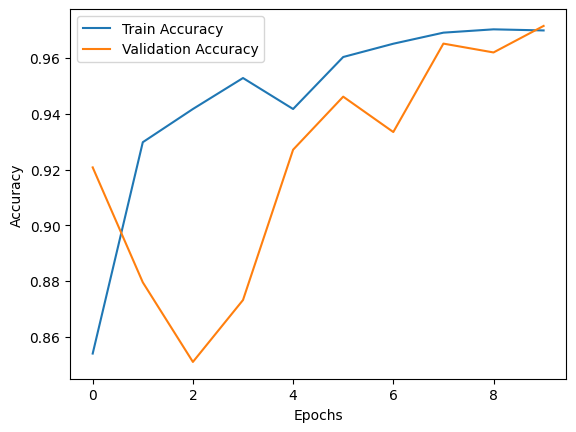

Total number of PVC beats in the dataset: 831
Total number of R-R peaks in the dataset: 3152

Visualizing 30-second ECG signal with PVCs highlighted...


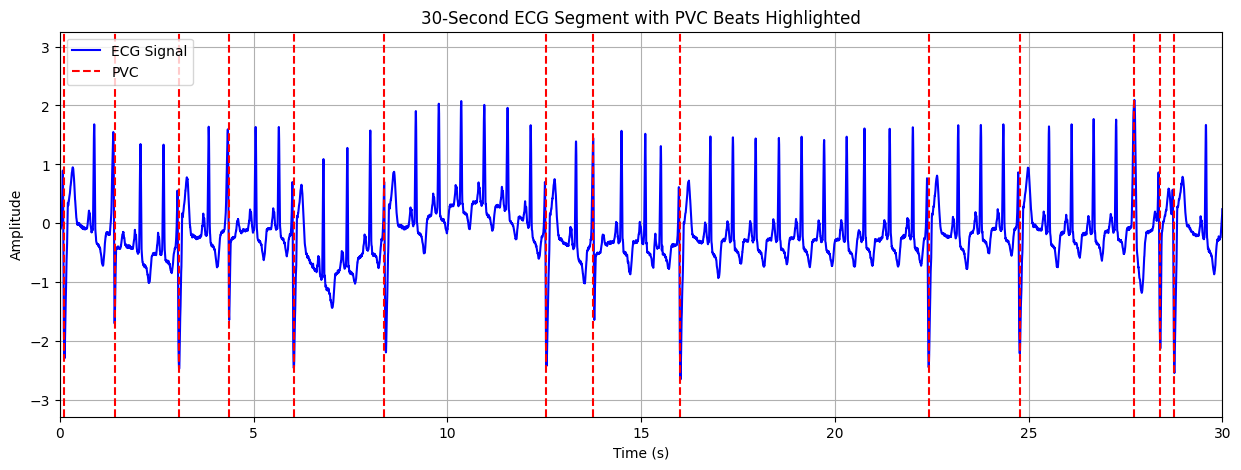

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 878ms/step
Sensitivity: 0.95
Specificity: 0.98
Positive Predictive Value (PPV): 0.93
Negative Predictive Value (NPV): 0.99
False Positive Rate (FPR): 0.02
False Negative Rate (FNR): 0.05
False Discovery Rate (FDR): 0.07
F1 Score: 0.94
Visualizing 30-second ECG signal with detected PVCs highlighted...


C:\Python 3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


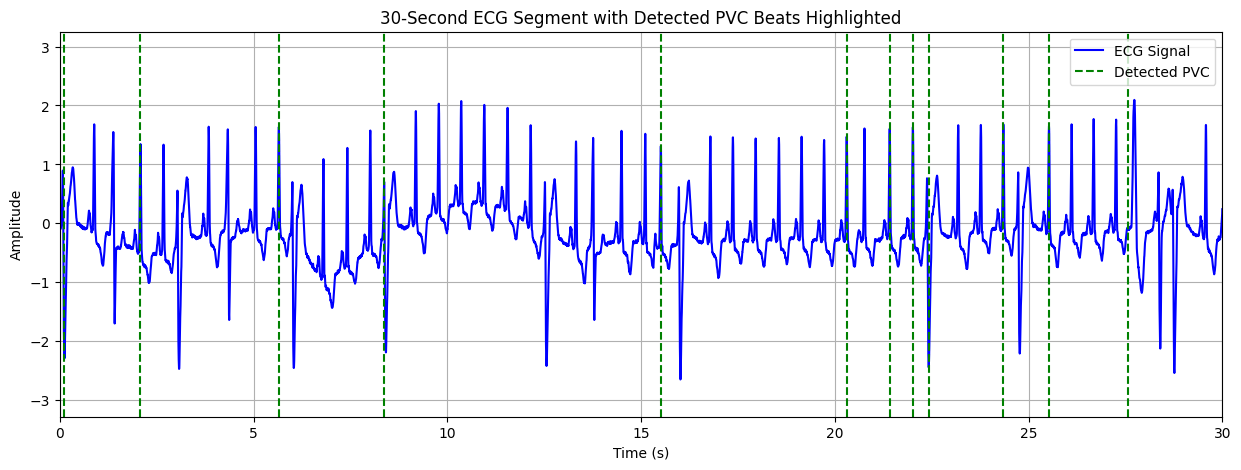

In [5]:
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Reshape, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import wfdb

# Helper function to extract combined features (Wavelet, Hilbert, WVD)
def extract_combined_features(signal):
    # Placeholder for combined feature extraction (implement this method as per your needs)
    return np.concatenate([
        signal,  # Original signal (placeholder)
        np.abs(np.fft.fft(signal)),  # FFT magnitude as placeholder
    ])

# Preprocess ECG data
def preprocess_data_with_combined_features(record_name, priority_signals, window_size=256):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal_names = record.sig_name
    available_signals = [sig for sig in priority_signals if sig in signal_names][:1]

    if len(available_signals) < 1:
        raise ValueError("No matching signals found in the priority list.")

    signals = {sig: record.p_signal[:, signal_names.index(sig)] for sig in available_signals}
    features, labels = [], []

    for i, sample in enumerate(annotation.sample):
        start = max(0, sample - window_size // 2)
        end = min(len(record.p_signal), sample + window_size // 2)

        signal_window = signals[available_signals[0]][start:end]
        if len(signal_window) < window_size:
            signal_window = np.pad(signal_window, (0, window_size - len(signal_window)), 'constant')

        combined_features = extract_combined_features(signal_window)
        features.append(combined_features)
        labels.append(1 if annotation.symbol[i] == 'V' else 0)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return np.array(features), np.array(labels), annotation, signals[available_signals[0]]

# Build optimized LSTM model
def build_optimized_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layers with attention
    lstm_out = LSTM(128, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    lstm_out = LSTM(64, return_sequences=False)(attention)

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer='l2')(lstm_out)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Plot waveform representation with PVC highlights
def plot_signal_with_pvc(signal, annotations, sample_rate, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify PVC beats within the selected window
    pvc_indices = [i for i, sym in enumerate(annotations.symbol) if sym == 'V']
    pvc_samples = [annotations.sample[i] for i in pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight PVC locations
    for pvc_sample in pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='red', linestyle='--', label="PVC" if pvc_sample == pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize detected PVC beats
def visualize_detected_pvc_beats(signal, annotations, sample_rate, y_pred, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify detected PVC beats within the selected window
    detected_pvc_indices = np.where(y_pred == 1)[0]
    detected_pvc_samples = [annotations.sample[i] for i in detected_pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight detected PVC locations
    for pvc_sample in detected_pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='green', linestyle='--', label="Detected PVC" if pvc_sample == detected_pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with Detected PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics calculations
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0  # False Discovery Rate
    f1 = f1_score(y_true, y_pred)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Positive Predictive Value (PPV): {ppv:.2f}")
    print(f"Negative Predictive Value (NPV): {npv:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Negative Rate (FNR): {fnr:.2f}")
    print(f"False Discovery Rate (FDR): {fdr:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Main function
def main(record_name, priority_signals):
    print("Preprocessing data...")
    features, labels, annotations, signal = preprocess_data_with_combined_features(record_name, priority_signals)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Reshape data to 3D for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Building and training model...")
    model = build_optimized_lstm_model(input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Count PVC and R peaks
    pvc_count = np.sum(labels)
    rr_peak_count = len(annotations.sample)

    print(f"Total number of PVC beats in the dataset: {pvc_count}")
    print(f"Total number of R-R peaks in the dataset: {rr_peak_count}")

    # Visualize the ECG signal
    print("\nVisualizing 30-second ECG signal with PVCs highlighted...")
    plot_signal_with_pvc(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, window_length=30)

    # Generate predictions and evaluate metrics
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    calculate_metrics(y_true, y_pred)

    # Visualize detected PVC beats
    print("Visualizing 30-second ECG signal with detected PVCs highlighted...")
    visualize_detected_pvc_beats(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, y_pred=y_pred, window_length=30)

# Example usage
record_name = "233"  # Replace with your record name
priority_signals = ["MLII", "II", "V5", "V4", "V2", "V1"]
main(record_name, priority_signals)


Preprocessing data...
Splitting data...
Building and training model...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.8324 - loss: 1.2601 - val_accuracy: 0.9622 - val_loss: 1.1331
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9629 - loss: 0.7008 - val_accuracy: 0.6957 - val_loss: 0.8757
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.9592 - loss: 0.5627 - val_accuracy: 0.6513 - val_loss: 0.6941
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 419s 10s/step - accuracy: 0.9630 - loss: 0.4072 - val_accuracy: 0.6464 - val_loss: 0.6372
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - accuracy: 0.9795 - loss: 0.2837 - val_accuracy: 0.6464 - val_loss: 0.5646
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step - accuracy: 0.9749 - loss: 0.2484 - val_accuracy: 0.8832 - val_loss: 0.4660
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 265s 7s/step - accuracy: 0.9741 - loss: 0.2073 - val_accuracy: 0.9556 - val_loss: 0.3685
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2

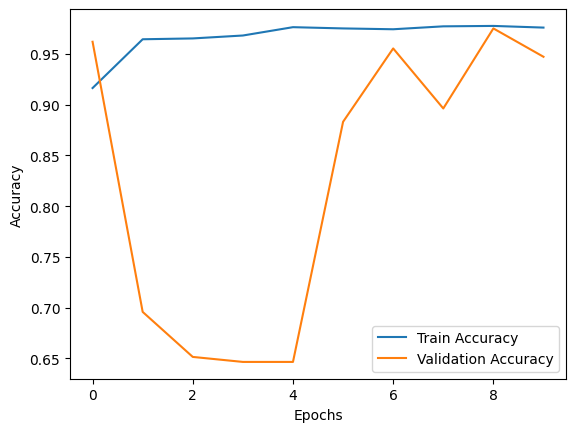

Total number of PVC beats in the dataset: 992
Total number of R-R peaks in the dataset: 3040

Visualizing 30-second ECG signal with PVCs highlighted...


C:\Python 3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


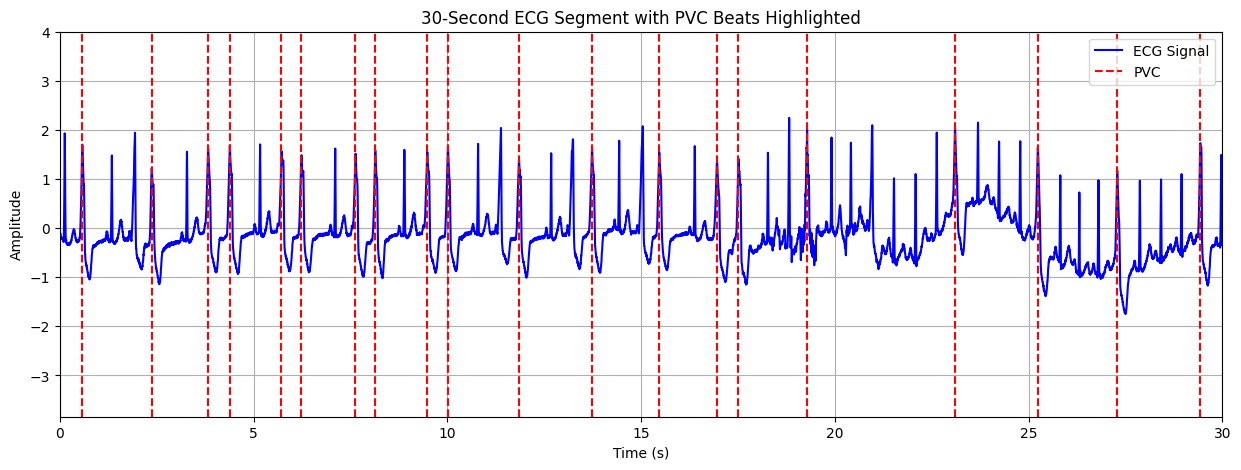

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step
Sensitivity: 0.85
Specificity: 1.00
Positive Predictive Value (PPV): 1.00
Negative Predictive Value (NPV): 0.92
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.15
False Discovery Rate (FDR): 0.00
F1 Score: 0.92


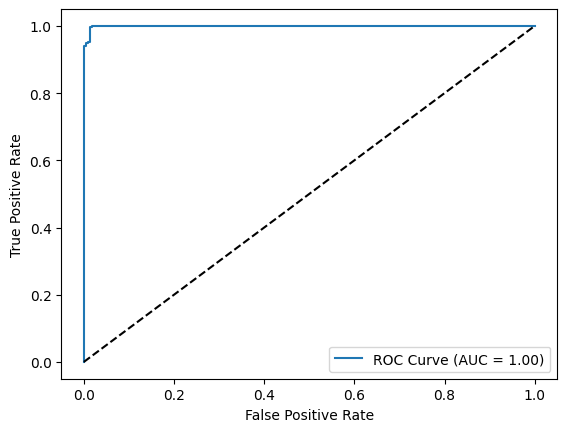

Visualizing 30-second ECG signal with detected PVCs highlighted...


C:\Python 3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


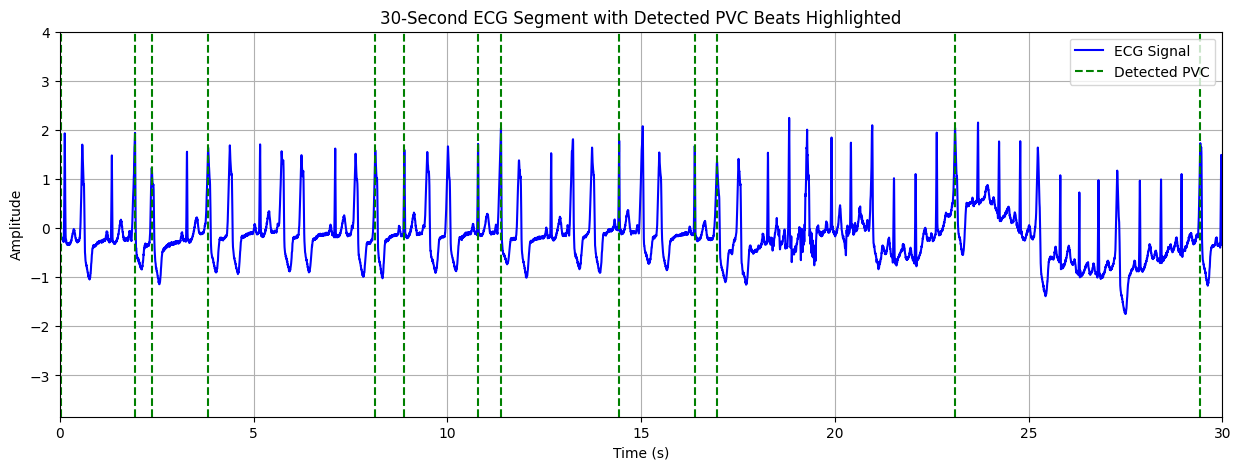

In [4]:
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Reshape, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import wfdb

# Helper function to extract combined features (Wavelet, Hilbert, WVD)
def extract_combined_features(signal):
    # Placeholder for combined feature extraction (implement this method as per your needs)
    return np.concatenate([
        signal,  # Original signal (placeholder)
        np.abs(np.fft.fft(signal)),  # FFT magnitude as placeholder
    ])

# Preprocess ECG data
def preprocess_data_with_combined_features(record_name, priority_signals, window_size=256):
    record = wfdb.rdrecord(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    signal_names = record.sig_name
    available_signals = [sig for sig in priority_signals if sig in signal_names][:1]

    if len(available_signals) < 1:
        raise ValueError("No matching signals found in the priority list.")

    signals = {sig: record.p_signal[:, signal_names.index(sig)] for sig in available_signals}
    features, labels = [], []

    for i, sample in enumerate(annotation.sample):
        start = max(0, sample - window_size // 2)
        end = min(len(record.p_signal), sample + window_size // 2)

        signal_window = signals[available_signals[0]][start:end]
        if len(signal_window) < window_size:
            signal_window = np.pad(signal_window, (0, window_size - len(signal_window)), 'constant')

        combined_features = extract_combined_features(signal_window)
        features.append(combined_features)
        labels.append(1 if annotation.symbol[i] == 'V' else 0)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return np.array(features), np.array(labels), annotation, signals[available_signals[0]]

# Build optimized LSTM model
def build_optimized_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layers with attention
    lstm_out = LSTM(128, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    lstm_out = LSTM(64, return_sequences=False)(attention)

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer='l2')(lstm_out)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Plot waveform representation with PVC highlights
def plot_signal_with_pvc(signal, annotations, sample_rate, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify PVC beats within the selected window
    pvc_indices = [i for i, sym in enumerate(annotations.symbol) if sym == 'V']
    pvc_samples = [annotations.sample[i] for i in pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight PVC locations
    for pvc_sample in pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='red', linestyle='--', label="PVC" if pvc_sample == pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize detected PVC beats
def visualize_detected_pvc_beats(signal, annotations, sample_rate, y_pred, window_length=30):
    plt.figure(figsize=(15, 5))
    time = np.linspace(0, len(signal) / sample_rate, len(signal))

    # Identify detected PVC beats within the selected window
    detected_pvc_indices = np.where(y_pred == 1)[0]
    detected_pvc_samples = [annotations.sample[i] for i in detected_pvc_indices]

    # Plot the signal
    plt.plot(time, signal, label="ECG Signal", color='blue')

    # Highlight detected PVC locations
    for pvc_sample in detected_pvc_samples:
        pvc_time = pvc_sample / sample_rate
        if pvc_time <= window_length:  # Highlight PVCs within the first 30 seconds
            plt.axvline(pvc_time, color='green', linestyle='--', label="Detected PVC" if pvc_sample == detected_pvc_samples[0] else "")

    plt.xlim(0, window_length)
    plt.title(f"30-Second ECG Segment with Detected PVC Beats Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics calculations
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0  # False Discovery Rate
    f1 = f1_score(y_true, y_pred)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Positive Predictive Value (PPV): {ppv:.2f}")
    print(f"Negative Predictive Value (NPV): {npv:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Negative Rate (FNR): {fnr:.2f}")
    print(f"False Discovery Rate (FDR): {fdr:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Main function
def main(record_name, priority_signals):
    print("Preprocessing data...")
    features, labels, annotations, signal = preprocess_data_with_combined_features(record_name, priority_signals)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Reshape data to 3D for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Building and training model...")
    model = build_optimized_lstm_model(input_shape=X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Count PVC and R peaks
    pvc_count = np.sum(labels)
    rr_peak_count = len(annotations.sample)

    print(f"Total number of PVC beats in the dataset: {pvc_count}")
    print(f"Total number of R-R peaks in the dataset: {rr_peak_count}")

    # Visualize the ECG signal
    print("\nVisualizing 30-second ECG signal with PVCs highlighted...")
    plot_signal_with_pvc(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, window_length=30)

    # Generate predictions and evaluate metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    calculate_metrics(y_true, y_pred)

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize detected PVC beats
    print("Visualizing 30-second ECG signal with detected PVCs highlighted...")
    visualize_detected_pvc_beats(signal, annotations, sample_rate=wfdb.rdrecord(record_name).fs, y_pred=y_pred, window_length=30)

# Example usage
record_name = "208"  # Replace with your record name
priority_signals = ["MLII", "II", "V5", "V4", "V2", "V1"]
main(record_name, priority_signals)
